# Image Classification Using PyTorch and ResNet152

In [3]:
import warnings
warnings.filterwarnings("ignore")

import torch

# Checking is CUDA is available so we can train on GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


## Data Splitting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#! tar -xvf 'data.tar.xz'

In [4]:
import json
import shutil
import random
import os

root = 'data/'

# Splitting the data into train, test and validation set
split_root = 'dataset/'
split_names = ['train','valid']
for sp_name in split_names:
    directory = split_root + sp_name + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    # make category folders
    for category in categories.keys():
        dir_cat = directory + category + '/'
        if not os.path.exists(dir_cat):
            os.makedirs(dir_cat)

for category in categories.keys():
    count = 0
    data_directory = root + category + '/'
    directory_train = split_root + 'train/' + category + '/'
    directory_valid = split_root + 'valid/' + category + '/'
    
    # sort files into test and valid folders
    filenames = os.listdir(data_directory)
    filenames.sort()
    if '.DS_Store' in filenames:
        filenames.remove('.DS_Store')
    random.shuffle(filenames)
    split = int(0.8 * len(filenames))
    train_filenames = filenames[:split]
    valid_filenames = filenames[split:]

    for image_file in filenames:
        if image_file in valid_filenames:
            shutil.copy(data_directory + image_file, directory_valid + image_file)
            cur_file = directory_valid + image_file
            new_file = directory_valid + category + str(count) + '.jpg'
            count += 1
            os.rename(cur_file, new_file)

        elif image_file in train_filenames:
            shutil.copy(data_directory + image_file, directory_train + image_file)
            cur_file = directory_train + image_file
            new_file = directory_train + category + str(count) + '.jpg'
            count += 1
            os.rename(cur_file, new_file)

## Data Loading and Pre-Processing

In [5]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os

In [6]:
data = "dataset"
train = data + '/train'
valid = data + '/valid'
batch_size = 32

In [7]:
# Defining the transforms for pre-processing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load the data from the directory
dataset = {x: datasets.ImageFolder(os.path.join(data, x),data_transforms[x])
                  for x in ['train', 'valid']}

# Load data to dataloader to return batches of images
dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=batch_size,shuffle=True)
              for x in ['train', 'valid']}

In [8]:
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'valid']}
print("Training size : ",dataset_sizes['train'])
print("Validation size : ",dataset_sizes['valid'])
class_names = dataset['train'].classes
print("Number of classes : ",len(class_names))

Training size :  5911
Validation size :  1479
Number of classes :  37


In [104]:
categories = {}
for i in range(len(class_names)):
  categories[class_names[i]] = class_names[i]

with open("label.json", "w") as outfile:  
    json.dump(categories, outfile)

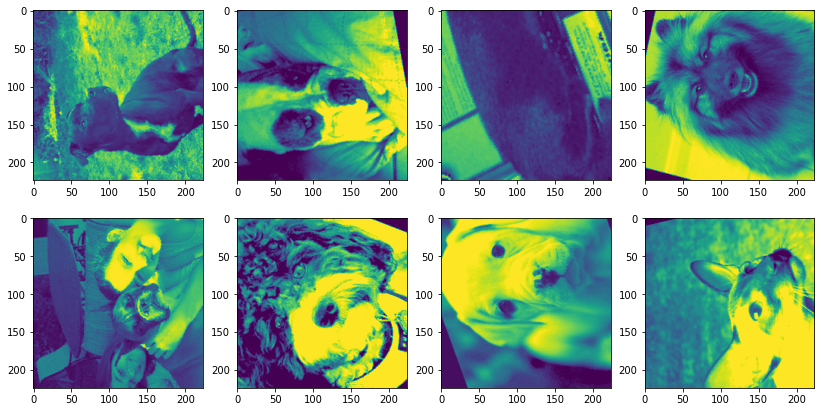

In [9]:
images, labels = next(iter(dataloaders['train']))
fig = plt.figure(figsize=(14,7))
for i in range(8):
    fig.add_subplot(2, 4, i+1)
    plt.imshow(images[i].T[:,:,0])

## Building and Training the Model

In [10]:
from torchvision import models
from torch import nn, optim
from torch.optim import lr_scheduler
import time
import copy

In [11]:
# Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)

#Checking the model architecture:
print(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [12]:
# Freeze parameters so we don't backprop through them during training
for param in model.parameters():
    param.requires_grad = False
    
# Re-define the final fully-connected layer
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 37),
                                 nn.LogSoftmax(dim=1))
    
# Creating loss function
criterion = nn.NLLLoss()

# Selecting the optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# Create schedular to decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Load model to GPU
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
def training(model, criterion, optimizer, scheduler, num_epochs):
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(1, num_epochs+1):
        
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
            
    total_time = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
if torch.cuda.is_available() == True :
    print ("Using GPU: "+ str(torch.cuda.is_available()))
    model = model.cuda()
    
num_epochs = 10
model_fit = training(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

Using GPU: True
Epoch 1/10
----------
train Loss: 1.5493 Acc: 0.5601
valid Loss: 0.4344 Acc: 0.8634

Epoch 2/10
----------
train Loss: 0.9409 Acc: 0.7061
valid Loss: 0.3123 Acc: 0.8925

Epoch 3/10
----------
train Loss: 0.8590 Acc: 0.7363
valid Loss: 0.3527 Acc: 0.8749

Epoch 4/10
----------
train Loss: 0.8682 Acc: 0.7310
valid Loss: 0.3298 Acc: 0.8851

Epoch 5/10
----------
train Loss: 0.7062 Acc: 0.7720
valid Loss: 0.2291 Acc: 0.9236

Epoch 6/10
----------
train Loss: 0.6790 Acc: 0.7914
valid Loss: 0.2231 Acc: 0.9195

Epoch 7/10
----------
train Loss: 0.6623 Acc: 0.7926
valid Loss: 0.2159 Acc: 0.9290

Epoch 8/10
----------
train Loss: 0.6228 Acc: 0.8083
valid Loss: 0.2073 Acc: 0.9317

Epoch 9/10
----------
train Loss: 0.6434 Acc: 0.7994
valid Loss: 0.2145 Acc: 0.9283

Epoch 10/10
----------
train Loss: 0.6183 Acc: 0.8063
valid Loss: 0.2067 Acc: 0.9324

Training complete in 19m 18s
Best valid accuracy: 0.932387


In [17]:
model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 37,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'Pytorch-ResNet152.pth')

## Loading model

In [81]:
def load_model(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    input_size = 2048
    output_size = 37
    
    model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 37),
                                 nn.LogSoftmax(dim=1))
        
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_model('Pytorch-ResNet152.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

## Model Evaluations

In [ ]:
from PIL import Image
from torch.autograd import Variable
import json

In [105]:
with open('label.json', 'r') as f:
    categories = json.load(f)

In [21]:
# To plot confusion matrix or find accuracy score

predictions, targets = [], []
for images, labels in dataloaders['valid']:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    images, labels = images.to(device), labels.to(device)
    logps = model(images)
    output = torch.exp(logps)
    pred = torch.argmax(output, 1)

    # convert to numpy arrays
    pred = pred.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    for i in range(len(pred)):
        predictions.append(pred[i])
        targets.append(labels[i])

In [75]:
def process_image(image):

    # Process a PIL image for use in a PyTorch model
    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))   
    return npImage

In [67]:
def predict(image_path, model, topk=4):
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx[:-1]]
    top_probability = pobabilities[top_idx[:-1]]

    return top_probability, top_class

In [127]:
# Display an image along with the top 2 classes
def view_classification(img, probabilities, classes, mapper):
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    name = mapper[img_filename]
    ax1.set_title(name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()
    for p in ax2.patches:
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy() 
      ax2.annotate(f'{width:.0%}', (x + height, y + height*0.5), ha='center')
    print("Accuracy = {0:.2f}%".format(probabilities[0]*100))

Accuracy = 89.08%


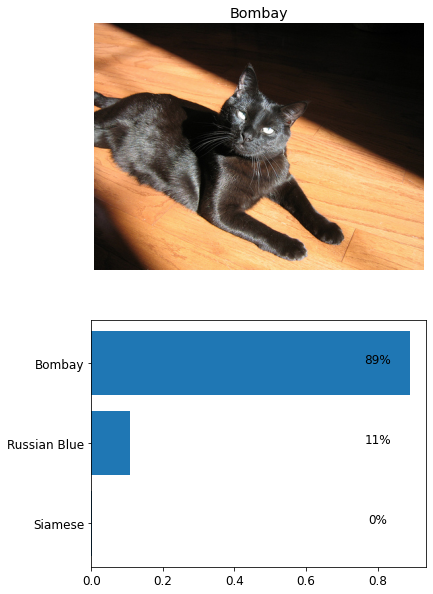

In [128]:
img = '/content/dataset/valid/Bombay/Bombay168.jpg'
p, c = predict(img, loaded_model)
view_classification(img, p, c, categories)

Accuracy = 98.59%


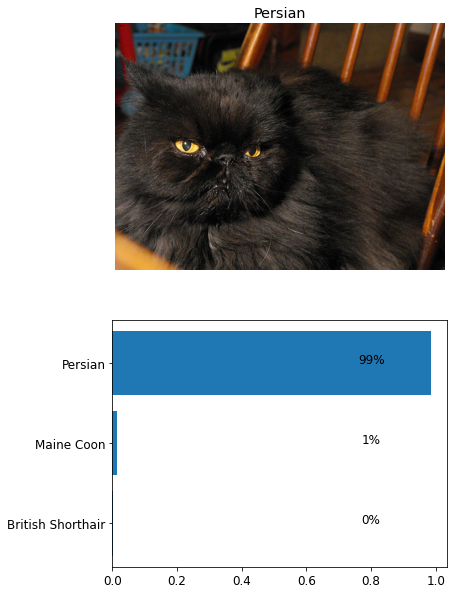

In [129]:
img = '/content/dataset/valid/Persian/Persian171.jpg'
p, c = predict(img, loaded_model)
view_classification(img, p, c, categories)